In [6]:
#import torch
import torchvision
from torchvision import models
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import imghdr
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [7]:
# Ограничитель на cpu
torch.set_num_threads(4)

In [8]:
#fasterrcnn_resnet50_fpn
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [9]:
# Ниже модификация методов
# ДЛЯ РАБОТЫ С ОДИНОКОЙ КАРТИНКОЙ
# Добавлены методы: 
# 1.предсказания наиболее вероятного класса(класса 1 объекта с наибольшей вероятностью)
# 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score

def my_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
        
  
def my_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(10,20))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

## Test block pics

In [ ]:
%%time
torch.set_num_threads(1)
#a = torch.get_num_threads()
my_get_prediction('../projects/data/Positive/112.jpg', threshold=0.1)

In [ ]:
my_get_prediction_class_output('./яхта.jpg', threshold=0.1)

In [ ]:
%%time
my_get_prediction_person_output('./яхта.jpg', threshold=0.1)

In [13]:
#img_path = './1360291657_dc248c5eea.jpg'
#img_path = './00000105_avatar-Copy1.png'
#img_path = '../projects/17.jpg'
#img_path = './african_crocodile_s_000011-Copy1.png'
#img_path = './people.jpg'
img_path = './look.jpg'
img = Image.open(img_path)
transform = T.Compose([T.ToTensor()])
img = transform(img)
img = img[0:3]
pred = model([img])
print(pred)

[{'boxes': tensor([[177.3016,  20.3183, 461.6702, 602.2914],
        [246.7653, 284.1800, 294.7520, 373.2834],
        [367.6091, 147.9877, 463.0586, 482.3610],
        [379.4408, 392.6466, 466.0136, 497.8568],
        [355.1067, 158.7638, 400.0671, 413.5856],
        [204.6465, 166.0200, 402.4118, 574.3186],
        [187.5258, 300.6383, 361.0793, 600.5464],
        [259.7822, 134.5058, 405.5040, 430.3824],
        [312.0847, 153.6806, 394.7299, 384.8651],
        [298.6784, 153.9671, 445.7278, 480.0529],
        [368.8784, 166.2025, 392.7190, 391.3221],
        [489.3100, 196.9659, 609.1650, 469.0097],
        [218.6966, 139.1549, 425.2148, 394.0682],
        [239.0508, 342.3663, 331.2640, 604.2805],
        [359.6617, 119.6385, 418.4765, 484.7819],
        [487.9386,  69.2597, 608.2559, 499.5873],
        [196.8983, 163.5599, 412.5467, 562.8214],
        [282.9235, 349.5584, 329.8431, 600.9619]], grad_fn=<StackBackward>), 'labels': tensor([ 1, 47, 31, 31, 31, 31, 31, 31, 31, 31, 31, 

In [14]:
img.size()

torch.Size([3, 610, 610])

In [15]:
img

tensor([[[0.5804, 0.5804, 0.5765,  ..., 0.1294, 0.1490, 0.1569],
         [0.5725, 0.5686, 0.5686,  ..., 0.1255, 0.1490, 0.1569],
         [0.5686, 0.5686, 0.5647,  ..., 0.1216, 0.1451, 0.1569],
         ...,
         [0.7451, 0.7451, 0.7451,  ..., 0.4824, 0.4980, 0.5020],
         [0.7490, 0.7451, 0.7451,  ..., 0.4706, 0.4941, 0.4941],
         [0.7451, 0.7451, 0.7412,  ..., 0.4706, 0.4902, 0.4902]],

        [[0.4941, 0.4941, 0.4902,  ..., 0.0902, 0.1059, 0.1137],
         [0.4863, 0.4824, 0.4824,  ..., 0.0863, 0.1059, 0.1137],
         [0.4745, 0.4745, 0.4784,  ..., 0.0824, 0.1020, 0.1137],
         ...,
         [0.7529, 0.7529, 0.7529,  ..., 0.4510, 0.4667, 0.4706],
         [0.7569, 0.7529, 0.7529,  ..., 0.4471, 0.4706, 0.4706],
         [0.7529, 0.7529, 0.7490,  ..., 0.4471, 0.4667, 0.4667]],

        [[0.4431, 0.4431, 0.4392,  ..., 0.0863, 0.0980, 0.1059],
         [0.4353, 0.4314, 0.4314,  ..., 0.0824, 0.0980, 0.1059],
         [0.4275, 0.4275, 0.4275,  ..., 0.0784, 0.0941, 0.

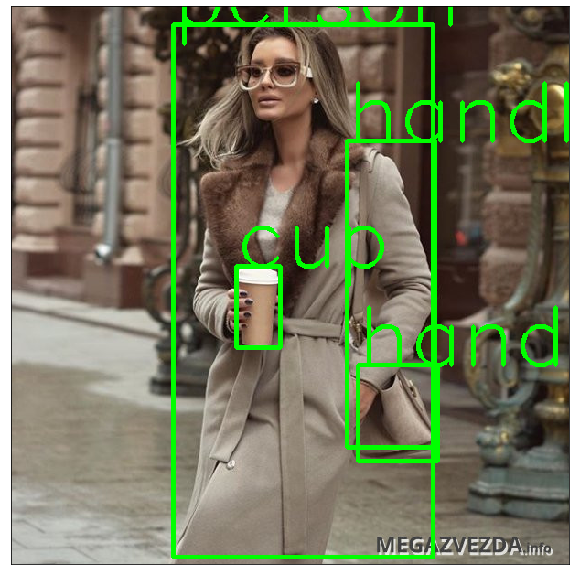

In [12]:
#my_object_detection_api('./40057579_avatar-Copy1.png', threshold=0.5)
#my_object_detection_api('../projects/data/Positive/112.jpg', threshold=0.1)
my_object_detection_api('./look.jpg', threshold=0.9)

### Validation from data/face

In [ ]:
import torch
import numpy as np
import imghdr
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


dataset = datasets.ImageFolder('data/face/val/',transform=transform)


test_size = 0.01
valid_size = 1
batch_size = 1

#For test
num_data = len(dataset)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#For Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset, sampler = test_sampler, batch_size=batch_size, 
    num_workers=1)
classes = [0,1]

In [ ]:
# !!!! ДЛЯ ДАТАСЕТА
# Добавлены методы: 1.предсказания наиболее вероятного класса 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  #img = Image.open(img_path)
  #transform = T.Compose([T.ToTensor()])
  #img = transform(img)
  img = img_path
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score

def my_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
 
def my_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_get_prediction(img_path, threshold)
  img = img_path
  #img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [ ]:
### Оценка качества бинарной классификации
def validation_model(threshold = 0.9):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    data_fp = []
    data_fn = []
    Precision = 0.
    Recall = 0.
    Acc = 0.
    i = 0
    
    for data, target in valid_loader:
        pred = my_get_prediction_person_output(data[0], threshold=threshold)
        #print(pred)
        #print(target)
        i += 1
        if i % 20 == 0:
            print('Progress bar:)',i)
        
        if pred == target:
            if pred == 1:
                tp += 1
            else:
                tn += 1
        else:
            if pred == 1:
                fp += 1
                data_fp.append(data[0])
            else:
                fn += 1
                data_fn.append(data[0])
    Precision = tp/(tp+fp)
    print('Precision',Precision)
    Recall = tp/(tp+fn)
    print('Recall',Recall)
    Acc = (tp+tn)/(tp+tn+fp+fn)
    print('Acc',Acc)
    return tp,tn,fp,fn,Acc,Precision,Recall,data_fp,data_fn
        

In [ ]:
%%time
#Валидация
a = validation_model(threshold = 0.95)

## Картиночки и оценки по тесту для HR

In [ ]:
# Data_Loader

transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 20
dataset = datasets.ImageFolder('data/test_m/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Data_Loader start

transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 20
dataset = datasets.ImageFolder('data/test_m/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

### Data_Loader end

### Картинки от HR: отрисовка и предсказание

pred_list = []

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images_n = images.numpy() # convert images to numpy for display
for i in images:
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(18):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:',labels[idx].item(),'Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
%%time

# Data_Loader
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 1
dataset = datasets.ImageFolder('data/test_m/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

a = validation_model(threshold = 0.95)

### Оценки по Mlife dataset 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Data_Loader start

transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 20
dataset = datasets.ImageFolder('data/mlife_photo/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)

### Data_Loader end

### Картинки от HR: отрисовка и предсказание

pred_list = []

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images_n = images.numpy() # convert images to numpy for display
for i in images:
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:',labels[idx].item(),'Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
%%time
torch.set_num_threads(4)

# Data_Loader
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 1
dataset = datasets.ImageFolder('data/mlife_photo/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)
#valid_loader = torch.utils.data.DataLoader(dataset,batch_size=len(dataset.imgs), num_workers=1)
a = validation_model(threshold = 0.95)

In [ ]:
len(x[8])

In [ ]:
### Картиночки FN

In [ ]:
#### Картиночки FN
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
### Возьмем из результатов list FN(a[8]) и перекинем в тензор
tt2 = torch.cat(a[8], dim = 0)
images_all = tt2.reshape([28,3,224,224])
images = images_all[18:28]
#####   
pred_list = [] 
    
images_n = images.numpy() # convert images to numpy for display
for i in images:
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(28, 4))
# display 20 images
#for idx in np.arange(28):
for idx in range(len(images_n)):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:1','Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
#my_get_prediction(images[13],threshold=0.1)
my_get_prediction(images[9],threshold=0.1)
#my_get_prediction_class_output(images,threshold=0.95)
#my_get_prediction_person_output(images,threshold=0.95)

In [ ]:
pred = model(images)
print(pred)

In [ ]:
#x

In [ ]:
#tt = torch.cat([x[0],x[1]], dim = 0)

### Модификация на более жесткие требования

In [ ]:
# !!!! ДЛЯ ДАТАСЕТА
# Добавлены методы: 1.предсказания наиболее вероятного класса 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  #img = Image.open(img_path)
  #transform = T.Compose([T.ToTensor()])
  #img = transform(img)
  img = img_path
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score


def my_get_prediction_person_tough(img_path, threshold, threshold_hum):
    ###
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    output = []
    # Кол-во уникальных классов для отсчения зашумленных картинок
    for class_num in pred_class_num:
        if class_num not in output:
            output.append(class_num)
    ### Person
    person = 0
    indx_list = []
    indx_list = [i for i, x in enumerate(pred_class_num) if x == 1] 
    for indx in indx_list:
        if pred_score[indx] > threshold_hum:
            person += 1
    
    if (len(output) < 5) and (person > 0) :
        prediction = 1
    else:
        prediction = 0
        
    return prediction

def my_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
 
def my_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_get_prediction(img_path, threshold)
  img = img_path
  #img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [ ]:
### Оценка качества бинарной классификации
def validation_model(threshold = 0.2, threshold_hum = 0.95 ):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    data_fp = []
    data_fn = []
    Precision = 0.
    Recall = 0.
    Acc = 0.
    i = 0
    
    for data, target in valid_loader:
        pred = my_get_prediction_person_tough(data[0], threshold=threshold, threshold_hum = threshold_hum)
        #print(pred)
        #print(target)
        i += 1
        if i % 20 == 0:
            print('Progress bar:)',i,tp,tn,fp,fn)
        
        if pred == target:
            if pred == 1:
                tp += 1
            else:
                tn += 1
        else:
            if pred == 1:
                fp += 1
                data_fp.append(data[0])
            else:
                fn += 1
                data_fn.append(data[0])
    Precision = tp/(tp+fp)
    print('Precision',Precision)
    Recall = tp/(tp+fn)
    print('Recall',Recall)
    Acc = (tp+tn)/(tp+tn+fp+fn)
    print('Acc',Acc)
    return tp,tn,fp,fn,Acc,Precision,Recall,data_fp,data_fn
        

In [ ]:
%%time
torch.set_num_threads(6)

# Data_Loader
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
batch_size = 1
dataset = datasets.ImageFolder('data/mlife_photo/',transform=transform)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1)
#valid_loader = torch.utils.data.DataLoader(dataset,batch_size=len(dataset.imgs), num_workers=1)
a = validation_model(threshold = 0.2, threshold_hum = 0.95 )
#print(a)

In [ ]:
#### Картиночки FN по консервативному алгоритму
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
### Возьмем из результатов list FN(a[8]) и перекинем в тензор
tt2 = torch.cat(a[8], dim = 0)
images_all = tt2.reshape([len(a[8]),3,224,224])
### Посмотрим k- результатов
k = len(a[8])
#k = 8
images = images_all[0:k]
#####   
pred_list = [] 
    
images_n = images.numpy() # convert images to numpy for display
for i in images:
    # Предсказываем менее консервативным алгоритмом
    pred = my_get_prediction_person_output(i, threshold=0.95)
    pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
#fig = plt.figure(figsize=(28, 4))
fig = plt.figure(figsize=(56, 8))
# display 20 images
#for idx in np.arange(28):
for idx in range(len(images_n)):
    ax = fig.add_subplot(8, k/8, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    ax.set_title(('Class:1','Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
#### Картиночки FN
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
### Возьмем из результатов list FN(a[8]) и перекинем в тензор
tt2 = torch.cat(a[8], dim = 0)
images_all = tt2.reshape([len(a[8]),3,224,224])
### Посмотрим k- результатов
k = len(a[8])
#k = 8
images = images_all[0:k]
#####   
pred_list = [] 
    
images_n = images.numpy() # convert images to numpy for display
#for i in images:
    # Предсказываем менее консервативным алгоритмом
    #pred = my_get_prediction_person_output(i, threshold=0.95)
    #pred_list.append(pred)

# plot the images in the batch, along with the corresponding labels
#fig = plt.figure(figsize=(28, 4))
fig = plt.figure(figsize=(56, 8))
# display 20 images
#for idx in np.arange(28):
for idx in range(len(images_n)):
    ax = fig.add_subplot(8, k/8, idx+1, xticks=[], yticks=[])
    imshow(images_n[idx])
    #ax.set_title(('Class:1','Pr:',pred_list[idx]))
    #ax.set_title(pred_list[idx])

In [ ]:
len(a[8])

In [ ]:
#img_path = './40057579_avatar-Copy1.png'

### Другие модели 

#### Alexnet 

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import imghdr


plt.ion()

In [ ]:
# Инициализация модели

###ALEXNET 2 class CrossEntropyLoss + Softmax
model_alex = torchvision.models.alexnet(pretrained=True)
# create two list for feature and classifier blocks
ft_list = list(model_alex.features)
cl_list = list(model_alex.classifier)

# Modifing feature block after removing the last max-pool layer (ft_list[12])
model_alex.features = nn.Sequential(ft_list[0], ft_list[1], ft_list[2],
                                  ft_list[3], ft_list[4], ft_list[5],
                                  ft_list[6], ft_list[7], ft_list[8],
                                  ft_list[9], ft_list[10], ft_list[11], ft_list[12])


# Modifing classifier block with a dropout and a fc layer only
cl_list[1] = nn.Linear(9216, 1000)
cl_list[2] = nn.Linear(1000, 2)
model_alex.classifier = nn.Sequential(cl_list[0], cl_list[1], cl_list[2],nn.Softmax() )
#model_alex = model_alex.to(device)


In [ ]:
# Подгрузка весов

import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
# load model cnn!
#model_alex = Net()
###ALEXNET 2 class CrossEntropyLoss + Softmax
model_alex = torchvision.models.alexnet(pretrained=True)
# create two list for feature and classifier blocks
ft_list = list(model_alex.features)
cl_list = list(model_alex.classifier)

# Modifing feature block after removing the last max-pool layer (ft_list[12])
model_alex.features = nn.Sequential(ft_list[0], ft_list[1], ft_list[2],
                                  ft_list[3], ft_list[4], ft_list[5],
                                  ft_list[6], ft_list[7], ft_list[8],
                                  ft_list[9], ft_list[10], ft_list[11], ft_list[12])


# Modifing classifier block with a dropout and a fc layer only
cl_list[1] = nn.Linear(9216, 1000)
cl_list[2] = nn.Linear(1000, 2)
model_alex.classifier = nn.Sequential(cl_list[0], cl_list[1], cl_list[2],nn.Softmax() )
#model_alex = model_alex.to(device)
model_alex.load_state_dict(torch.load('model_alexnet.pt'))
model_alex.eval()
model_alex.state_dict()

#### MRCNN

In [ ]:
#maskrcnn_resnet50_fpn
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [ ]:
my_get_prediction('./images.jpg', threshold=0.1)

In [ ]:
my_get_prediction_class_output('./images.jpg', threshold=0.1)

In [ ]:
my_get_prediction_person_output('./images.jpg', threshold=0.1)

In [ ]:
#my_object_detection_api('./images.jpg', threshold=0.1)

#### Keypoint R-CNN

In [ ]:
#torchvision.models.detection.keypointrcnn_resnet50_fpn
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COCO_PERSON_KEYPOINT_NAMES = [
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle'
]

In [ ]:
# Ниже модификация методов
# ДЛЯ РАБОТЫ С ОДИНОКОЙ КАРТИНКОЙ
# Добавлены методы: 
# 1.предсказания наиболее вероятного класса(класса 1 объекта с наибольшей вероятностью)
# 2.предсказания person/not person
# Добавлена устойчивость для случаев , когда предсказание пустое после отсечения трешхолдом

def my_face_get_prediction(img_path, threshold):
  """
  Мое расширение - дополнительно отдает score и номер класса
  
  get_prediction
    parameters:
    
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
        Если по условию отсечения параметром threshold нет ни одного предсказанного класса - ответ (999,1)
        
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  #У наших картинок почему-то 4 измерения, последнее измерение тензор с 1. Отсечем его   
  if img.size()[0] > 3:
        img = img[0:3]
  ### End
  pred = model([img])
  pred_class = [COCO_PERSON_KEYPOINT_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_class_num = list(pred[0]['labels'].detach().numpy())
  ###
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if pred_t.count(0) == 0:
        pred_boxes = [0]
        pred_class = [999]
        pred_score = [1]
        pred_class_num = [999]
  else:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_class_num = pred_class_num[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class_num, pred_class, pred_score

def my_face_get_prediction_class_output(img_path, threshold):
    ###Мое расширение - отдает the most probable class and score output
    boxes, pred_class_num, pred_class, pred_score = my_get_prediction(img_path, threshold)
    pred_class = pred_class[0]
    pred_score = pred_score[0]
    pred_class_num = pred_class_num[0]
    return  pred_class_num, pred_class, pred_score

def my_face_get_prediction_person_output(img_path, threshold):
    ###Мое расширение - отдает решение person/not person
    pred_class_num, pred_class, pred_score = my_get_prediction_class_output(img_path, threshold)
    if pred_class_num == 1:
        prediction = 1
    else:
        prediction = 0
    return prediction
        
  
def my_face_object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  # pred_boxes, pred_class_num, pred_class, pred_score
  boxes, _ , pred_cls, _ = my_face_get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #print(boxes)
  if boxes != [0]:
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
my_face_get_prediction('./images.jpg', threshold=0.1)

In [ ]:
my_face_object_detection_api('./images.jpg', threshold=0.1)